In [2]:
import pandas as pd
import numpy as np

# Load dataset
file_path = r"C:\Users\zaydz\Downloads\predictive-maintenance-dataset.csv\predictive-maintenance-dataset.csv"
df = pd.read_csv(file_path)

# Menampilkan 5 baris pertama untuk melihat strukturnya
print(df.head())

print(df.isnull().sum())  # Cek apakah ada nilai NaN di setiap kolom
print(np.isinf(df).sum())  # Cek apakah ada nilai Infinity


   ID  revolutions  humidity  vibration       x1      x2        x3  \
0   1       93.744    73.999       18.0  167.743  19.745  1.266828   
1   2       93.740    73.999       18.0  167.739  19.741  1.266774   
2   3       93.736    73.998       18.0  167.734  19.738  1.266737   
3   4       93.732    73.998       18.0  167.730  19.734  1.266683   
4   5       93.729    73.998       18.0  167.727  19.731  1.266642   

            x4           x5  
0  8787.937536  5475.852001  
1  8787.187600  5475.852001  
2  8786.437696  5475.704004  
3  8785.687824  5475.704004  
4  8785.125441  5475.704004  
ID                0
revolutions       0
humidity          0
vibration      2438
x1                0
x2                0
x3                0
x4                0
x5                0
dtype: int64
ID             0
revolutions    0
humidity       0
vibration      0
x1             0
x2             0
x3             0
x4             0
x5             0
dtype: int64


Epoch 1/5
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 125s 38ms/step - loss: 0.0608 - val_loss: 0.0042
Epoch 2/5
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 117s 42ms/step - loss: 0.0093 - val_loss: 0.0041
Epoch 3/5
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 106s 38ms/step - loss: 0.0071 - val_loss: 0.0042
Epoch 4/5
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 116s 41ms/step - loss: 0.0062 - val_loss: 0.0039
Epoch 5/5
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 131s 38ms/step - loss: 0.0058 - val_loss: 0.0042
700/700 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step

🚨 Jadwal Maintenance Lift:
🔧 Maintenance diperlukan pada: 09-07-2028
🔧 Maintenance diperlukan pada: 15-11-2029
🔧 Maintenance diperlukan pada: 18-11-2029
🔧 Maintenance diperlukan pada: 27-11-2029


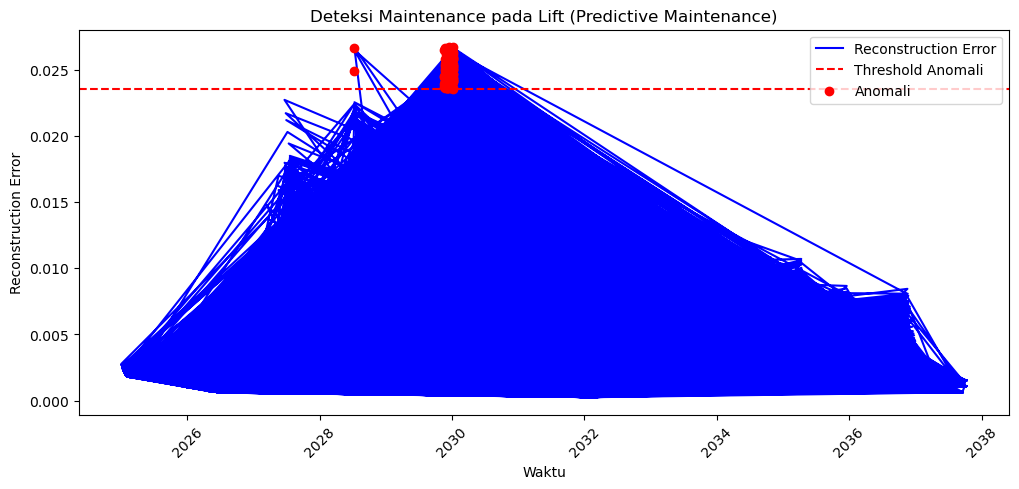

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Input
from tensorflow.keras.optimizers import Adam

# 1. Load Data
file_path = r"C:\Users\zaydz\Downloads\predictive-maintenance-dataset.csv\predictive-maintenance-dataset.csv"
df = pd.read_csv(file_path)

# 2. Cek & Bersihkan Data
df.ffill(inplace=True)  # Mengatasi NaN dengan forward fill

if 'ID' in df.columns:
    df.drop(columns=['ID'], inplace=True)

# 3. Tambahkan Kolom Timestamp 
df['timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='h')

# 4. Normalisasi Data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.drop(columns=['timestamp'])), columns=df.columns[:-1])

# 5. Buat Data Sequence (Time-Series)
time_steps = 10
num_features = df_scaled.shape[1]

def create_sequences(data, time_steps):
    sequences = []
    for i in range(len(data) - time_steps):
        sequences.append(data.iloc[i : i + time_steps].values)
    return np.array(sequences)

X_seq = create_sequences(df_scaled, time_steps)
timestamps_seq = df['timestamp'].iloc[time_steps:].values  # Simpan timestamp yang sesuai

# 6. Split Data untuk Training & Testing
X_train, X_test, timestamps_train, timestamps_test = train_test_split(X_seq, timestamps_seq, test_size=0.2, random_state=42)

# 7. Bangun Model Autoencoder CNN-LSTM
model = Sequential([
    Input(shape=(time_steps, num_features)),  # Perbaikan input shape
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    LSTM(50, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    RepeatVector(time_steps),
    LSTM(50, activation='relu', return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))
])

# 8. Compile Model
optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mse')

# 9. Training Model
history = model.fit(X_train, X_train, 
                    validation_data=(X_test, X_test), 
                    epochs=5, batch_size=32, verbose=1)

# 10. Prediksi & Hitung Error Rekonstruksi
X_pred = model.predict(X_test)
mse = np.mean(np.power(X_test - X_pred, 2), axis=(1, 2))

# 11. Tentukan Threshold Anomali
threshold = np.percentile(mse, 99)
anomalies = mse > threshold
anomaly_timestamps = timestamps_test[anomalies]  # Ambil waktu anomali terjadi

# 12. Urutkan & Format Tanggal
anomaly_timestamps = pd.to_datetime(anomaly_timestamps)  # Konversi ke datetime
anomaly_timestamps = anomaly_timestamps.sort_values()  # Urutkan dari yang terkecil

# 13. Kelompokkan anomali dalam rentang 24 jam
maintenance_dates = []
current_group = [anomaly_timestamps[0]]

for i in range(1, len(anomaly_timestamps)):
    if (anomaly_timestamps[i] - current_group[-1]) <= pd.Timedelta(hours=24):
        current_group.append(anomaly_timestamps[i])
    else:
        maintenance_dates.append(current_group[0])  # Simpan hanya tanggal awal
        current_group = [anomaly_timestamps[i]]

# Tambahkan tanggal terakhir
if current_group:
    maintenance_dates.append(current_group[0])

# Format tanggal menjadi DD-MM-YYYY
formatted_dates = [date.strftime("%d-%m-%Y") for date in maintenance_dates]

# 14. Tampilkan Waktu Maintenance yang Dibutuhkan
print("\n🚨 Jadwal Maintenance Lift:")
for date in formatted_dates:
    print(f"🔧 Maintenance diperlukan pada: {date}")

# 15. Visualisasi Anomali
plt.figure(figsize=(12, 5))
plt.plot(timestamps_test, mse, label="Reconstruction Error", color="blue")
plt.axhline(threshold, color='r', linestyle='dashed', label="Threshold Anomali")
plt.scatter(anomaly_timestamps, mse[anomalies], color='red', label="Anomali", zorder=3)
plt.xlabel("Waktu")
plt.ylabel("Reconstruction Error")
plt.title("Deteksi Maintenance pada Lift (Predictive Maintenance)")
plt.xticks(rotation=45)
plt.legend()
plt.show() 


📊 **Evaluasi Model:**
🔹 Mean Squared Error (MSE)  : 0.004169
🔹 Mean Absolute Error (MAE): 0.030397
🔹 R² Score                 : 0.942929

📊 **Confusion Matrix:**
[[22175     0]
 [    0   224]]

📊 **Classification Report:**
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     22175
     Anomali       1.00      1.00      1.00       224

    accuracy                           1.00     22399
   macro avg       1.00      1.00      1.00     22399
weighted avg       1.00      1.00      1.00     22399



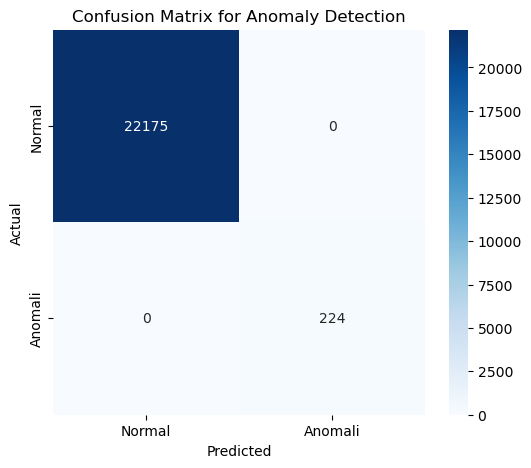

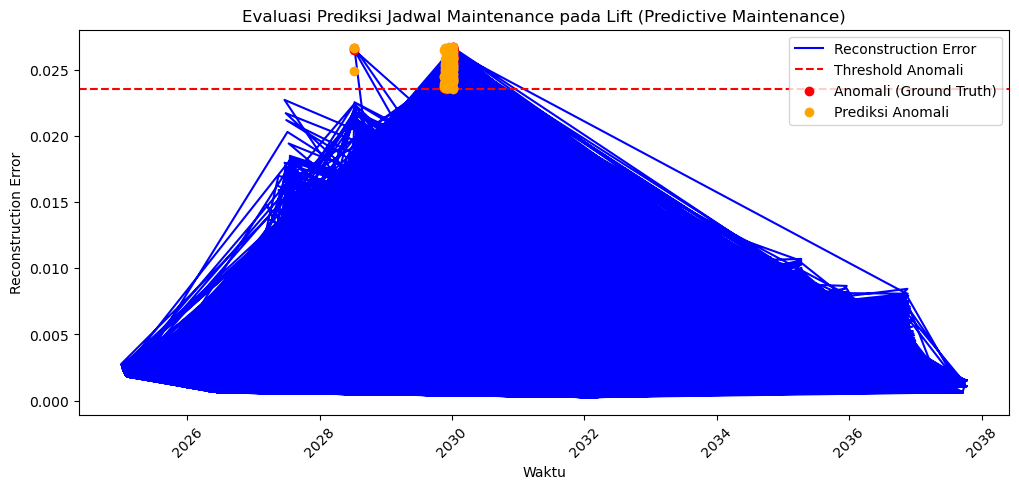

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, classification_report

# Evaluasi Metrik Dasar
mse_score = mean_squared_error(X_test.flatten(), X_pred.flatten())
mae_score = mean_absolute_error(X_test.flatten(), X_pred.flatten())
r2 = r2_score(X_test.flatten(), X_pred.flatten())

print("\n📊 **Evaluasi Model:**")
print(f"🔹 Mean Squared Error (MSE)  : {mse_score:.6f}")
print(f"🔹 Mean Absolute Error (MAE): {mae_score:.6f}")
print(f"🔹 R² Score                 : {r2:.6f}")

# Konversi hasil ke bentuk klasifikasi anomali (0 = Normal, 1 = Anomali)
y_true = anomalies.astype(int)  # 1 jika anomali, 0 jika normal
y_pred = (mse > threshold).astype(int)

# Confusion Matrix & Classification Report
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=["Normal", "Anomali"])

print("\n📊 **Confusion Matrix:**")
print(conf_matrix)

print("\n📊 **Classification Report:**")
print(class_report)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomali"], yticklabels=["Normal", "Anomali"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Anomaly Detection")
plt.show()

# Visualisasi MSE dengan Ground Truth (Jika Data Label Anomali Ada)
plt.figure(figsize=(12, 5))
plt.plot(timestamps_test, mse, label="Reconstruction Error", color="blue")
plt.axhline(threshold, color='r', linestyle='dashed', label="Threshold Anomali")

# Highlight data yang benar-benar anomali berdasarkan label (jika tersedia)
if sum(y_true) > 0:
    plt.scatter(timestamps_test[y_true == 1], mse[y_true == 1], color='red', label="Anomali (Ground Truth)", zorder=3)

plt.scatter(anomaly_timestamps, mse[anomalies], color='orange', label="Prediksi Anomali", zorder=3)

plt.xlabel("Waktu")
plt.ylabel("Reconstruction Error")
plt.title("Evaluasi Prediksi Jadwal Maintenance pada Lift (Predictive Maintenance)")
plt.xticks(rotation=45)
plt.legend()
plt.show()